# Teeth Disease Prediction

### 1 - Import Libraries & Load the Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D

In [2]:
# Reproducability
def set_seed(seed=125):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(125)

In [3]:
# Dataset Paths
main_dir = '/kaggle/input/teeth-diseases-dataset/Teeth_Dataset'

train_dir = os.path.join(main_dir, 'Training')
test_dir = os.path.join(main_dir, 'Testing')
val_dir = os.path.join(main_dir, 'Validation')

### 2 - Visualization

In [4]:

def count_images_per_class(dataset_dir, set_type):
    # Get class labels (subfolders)
    cls_labels = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    # Count images in each subfolder
    image_counts = {
        folder: len([
            f for f in os.listdir(os.path.join(dataset_dir, folder))
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        for folder in cls_labels
    }

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title(f"Number of Images per Class in {set_type} Set")
    plt.xticks(rotation=45)
    plt.show()
    return image_counts

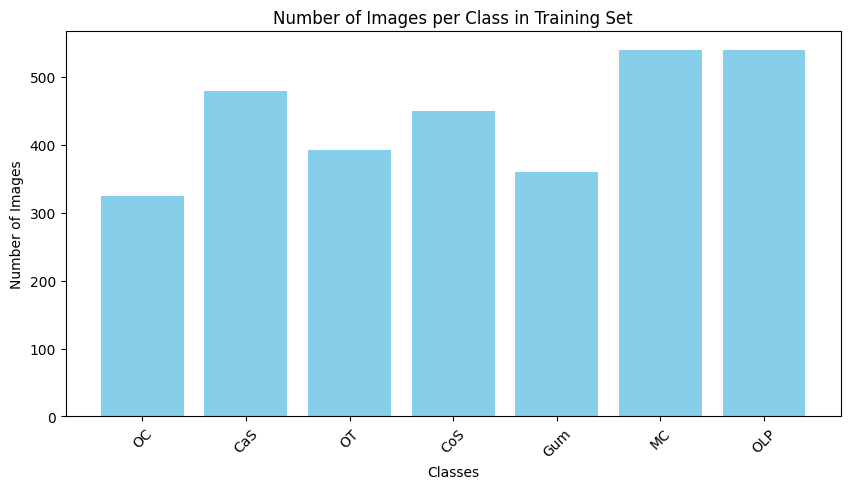

{'OC': 324,
 'CaS': 480,
 'OT': 393,
 'CoS': 450,
 'Gum': 360,
 'MC': 540,
 'OLP': 540}

In [5]:
count_images_per_class(train_dir, 'Training')

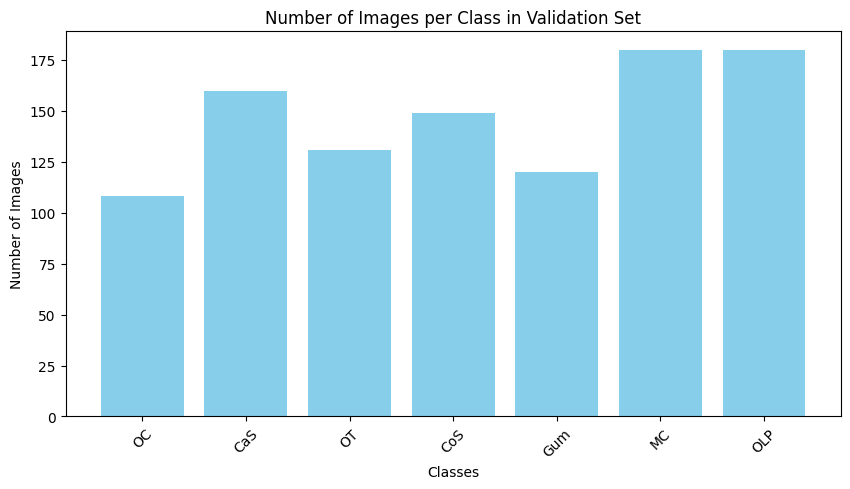

{'OC': 108,
 'CaS': 160,
 'OT': 131,
 'CoS': 149,
 'Gum': 120,
 'MC': 180,
 'OLP': 180}

In [6]:
count_images_per_class(val_dir, 'Validation')

### 3- Augmentation

In [7]:
train_datagen = ImageDataGenerator(

    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    rescale=1/255.
)

In [8]:
# Define image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


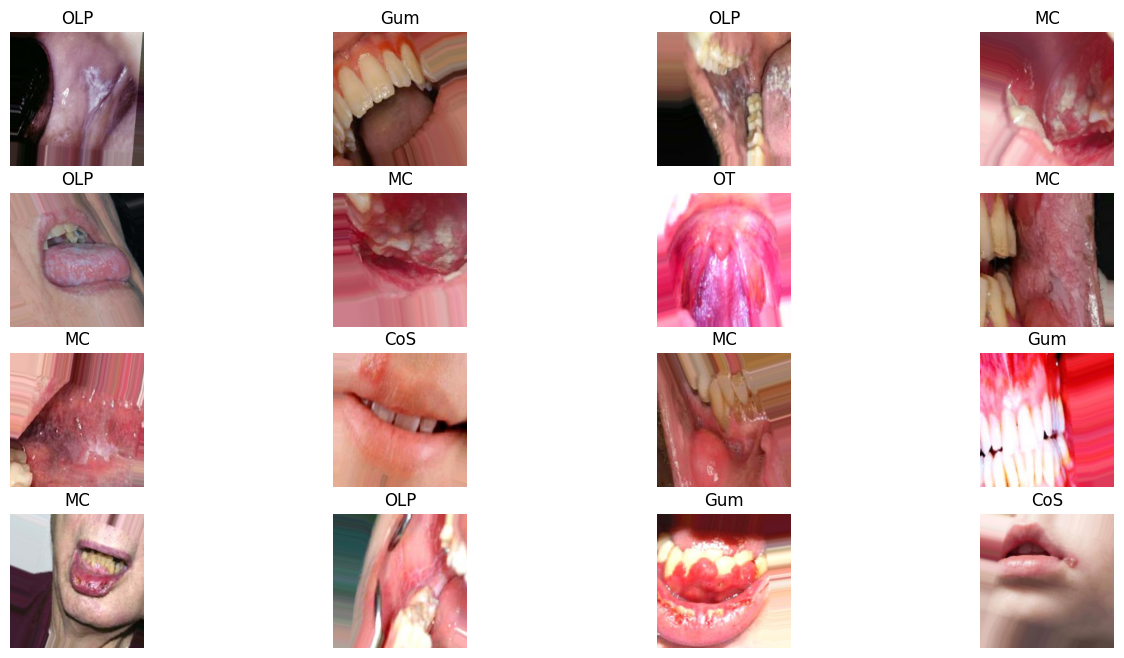

In [9]:
class_names = ['CaS', 'CoS', 'Gum','MC','OC','OLP','OT']

# Visualize Augmentation
def visualize_augmentation(generator):
    augmented_image, label = next(train_generator)
    plt.figure(figsize=(16,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_image[i])
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

    plt.show()

visualize_augmentation(train_generator)

### 4- Model Architecture and Training


In [11]:
# Load the Pretrained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True 
for layer in base_model.layers[:-10]:
    layer.trainable = False   # unfreeze last 10 layers

model = Sequential([
    base_model,  # Add Pretrained Base Model
    GlobalAveragePooling2D(),  
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(7, activation='softmax') 
])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,431,431 (9.28 MB)

 Trainable params: 905,543 (3.45 MB)

 Non-trainable params: 1,525,888 (5.82 MB)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
              loss='categorical_crossentropy',  
              metrics=['accuracy'])  


In [13]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'teeth_classification.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [14]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [15]:
# ReduceLROnPlateau: Reduce the learning rate when the metric has stopped improving.
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [16]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50 ,  callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 755ms/step - accuracy: 0.2897 - loss: 1.8946 - val_accuracy: 0.2928 - val_loss: 2.0453 - learning_rate: 1.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 389ms/step - accuracy: 0.6100 - loss: 1.1522 - val_accuracy: 0.3414 - val_loss: 2.1302 - learning_rate: 1.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 390ms/step - accuracy: 0.7235 - loss: 0.8773 - val_accuracy: 0.3735 - val_loss: 2.0454 - learning_rate: 1.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 387ms/step - accuracy: 0.7821 - loss: 0.7536 - val_accuracy: 0.3979 - val_loss: 2.1295 - learning_rate: 1.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 390ms/step - accuracy: 0.8128 - loss: 0.6516 - val_accuracy: 0.4125 - val_loss: 1.9622 - learning_rate: 5.0000e-05
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 393ms/step - accuracy: 0.8436 - loss: 0.5923 - val_accuracy: 0.5000 - val_loss: 1.5488 - learning_rate: 5.0000e-05
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 425ms/step - accuracy: 0.85

In [17]:
# function to plot accuracy and loss

def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):

    plt.figure(figsize=(10,5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')

    plt.ylabel('Accuracy')
    plt.legend(loc=0)

    # Create a new figure with plt.figure()
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

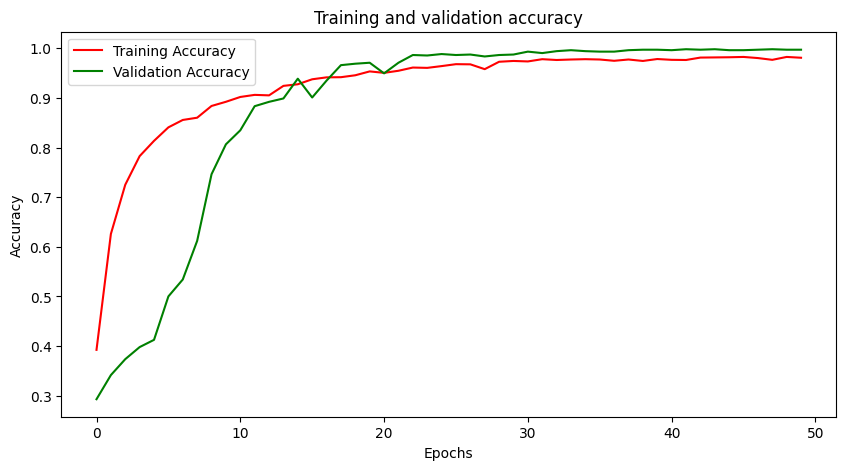

<Figure size 640x480 with 0 Axes>

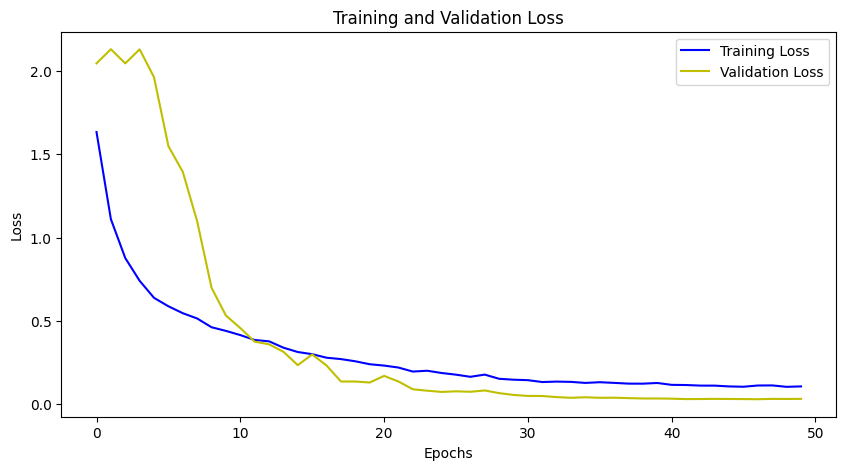

In [18]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = history.epoch

plot_acc_loss(acc, val_acc, loss, val_loss, epochs)

### 5- Model Evaluation

In [19]:
val_loss, val_accuracy = model.evaluate(val_generator)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9974 - loss: 0.0340
Validation loss: 0.0302496999502182
Validation accuracy: 0.9970816969871521


In [20]:
# Save the model
model.save('teeth_cls_using_mobileNetv2.h5')

In [21]:
#load model
model = load_model('teeth_cls_using_mobileNetv2.h5', compile= False)

Found 1028 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step


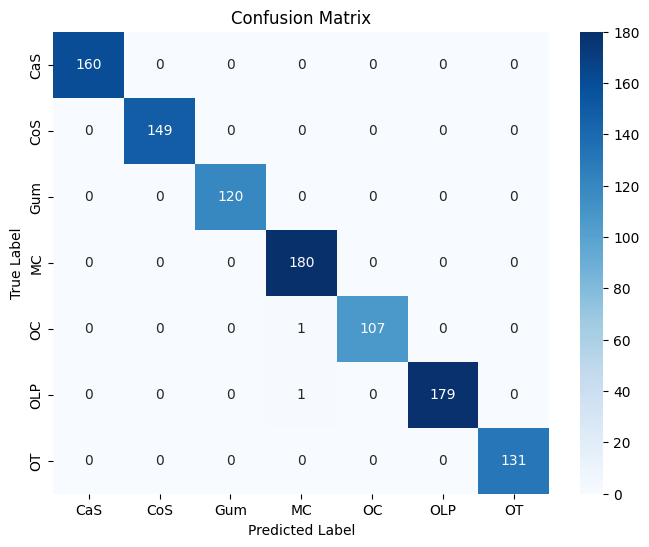

              precision    recall  f1-score   support

         CaS       1.00      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      1.00      0.99       180
          OC       1.00      0.99      1.00       108
         OLP       1.00      0.99      1.00       180
          OT       1.00      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028



In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# create test generator 
test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False) # shuffle=False to maintain order

# Get true labels and predictions
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Get predictions
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))